# Import data

In [1]:
import pandas as pd

df = pd.read_csv("Walmart_sales.csv")
df.head()

/var/folders/21/58bt0s757gn7hrffkk670h900000gn/T/ipykernel_1933/3122646254.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


# Data Exploration

## Individual Feature Exploration

### Stores

### Date

### Weekly Sales

### Holiday Flag

### Tempature

### Fuel Price

<Axes: >

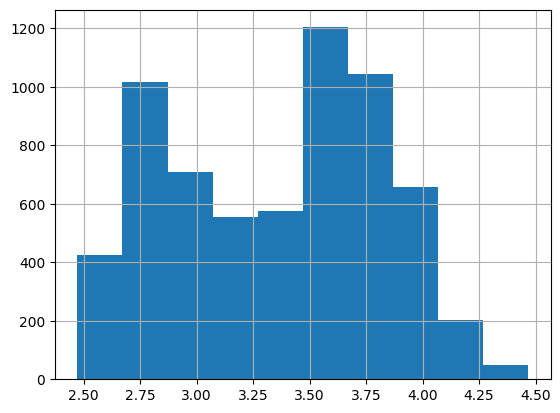

In [2]:
#view histogram for fuel price
df['Fuel_Price'].hist()

We have a bimodal distribution for our fuel prices 

In [5]:
#view summary statistics
mean = df['Fuel_Price'].mean()
stdDev = df['Fuel_Price'].std()


print(f"mean: {mean}")
print(f"Standard Devation: {stdDev}")


mean: 3.358606837606838
Standard Devation: 0.4590197071928525


### Consumer Price Index

### Unemployment

## Feature vs Sales

### Holiday vs Sales

### Tempature vs Sales

### Fuel Price vs Sales

### CPI vs Sales

### Unemployment vs Sales